# NBA shallow analysis

<h2>Intro</h2>

<p><b>Riddle: </b>"<br/><em>If I get thrown in the air, I will fall down.
    If I get thrown down, I will rise up.
    <b>What am I ?</b></em>"</p>
<p>Now lets get into serious stuff.
In this assignment I will analyze some NBA stats because it
is interesting, and can also be useful for betting purposes.
First we need to get some stats from tables.
NBA actually does not have these stats available for download
so I had to do some improvization with copy+paste+find+replace.
Why NBA? Because playoffs are just about to start.
Why is this written in english?
Beacuse english is the language of science.
</p>

In [1]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
players = pd.read_csv('players.csv')

In [3]:
players.columns

Index(['PLAYER', 'TEAM', 'AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-'],
      dtype='object')

In [5]:
players.head()

,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
0,James Harden,HOU,29,76,50,26,36.9,36.2,10.8,24.6,...,6.5,7.6,5.0,2.0,0.8,3.1,58.7,32,7,4.2
1,Paul George,OKC,28,75,44,31,36.8,28.1,9.2,20.9,...,8.2,4.1,2.7,2.2,0.5,2.7,49.2,24,1,6.3
2,Giannis Antetokounmpo,MIL,24,71,55,16,32.9,27.7,10.0,17.4,...,12.5,5.9,3.8,1.3,1.5,3.3,56.2,54,5,9.0
3,Joel Embiid,PHI,25,63,42,21,33.8,27.6,9.1,18.8,...,13.7,3.6,3.6,0.7,1.9,3.3,53.8,57,2,5.7
4,Stephen Curry,GSW,31,67,50,17,34.2,27.6,9.2,19.6,...,5.4,5.3,2.8,1.4,0.4,2.4,44.4,3,0,9.7


As you can see, there are a lot of columns, so I will start by removing ones that are unnecessary. To determine if some column is unnecessary, some computations are going to be used.

In [6]:
((players['3PM'] / players['3PA'])*100-players['3P%']).abs().mean()

0.9553824911929396

We use $perc = \frac{ThreePointsMade}{ThreePointsAttempted}*100$

Which should be equal to 3P%, but apparently there are some mistakes in tables and also there is only rounded to one number after decimal point.
So similarly we calculate for FG.

In [7]:
((players['FGM'] / players['FGA'])*100-players['FG%']).abs().mean()

0.1854524508098703

In [8]:
((players['FTM'] / players['FTA'])*100-players['FT%']).abs().mean()

0.9308365093055212

In [9]:
(players['GP'] - players['W'] - players['L']).abs().max()

0

In [10]:
del players['FGM']
del players['FGA']
#3PM will be later deleted, 
#cause we need it for fantasy function
del players['3PA']
del players['FTA']
del players['FTM']
del players['GP']

In [11]:
players.columns

Index(['PLAYER', 'TEAM', 'AGE', 'W', 'L', 'MIN', 'PTS', 'FG%', '3PM', '3P%',
       'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP',
       'DD2', 'TD3', '+/-'],
      dtype='object')

In [12]:
players.head(3)

,PLAYER,TEAM,AGE,W,L,MIN,PTS,FG%,3PM,3P%,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
0,James Harden,HOU,29,50,26,36.9,36.2,44.0,4.8,36.5,...,6.5,7.6,5.0,2.0,0.8,3.1,58.7,32,7,4.2
1,Paul George,OKC,28,44,31,36.8,28.1,44.0,3.8,38.9,...,8.2,4.1,2.7,2.2,0.5,2.7,49.2,24,1,6.3
2,Giannis Antetokounmpo,MIL,24,55,16,32.9,27.7,57.7,0.7,25.3,...,12.5,5.9,3.8,1.3,1.5,3.3,56.2,54,5,9.0


Other statistical variables are kinda unique, except rebounds where $REB = OREB + DREB$, but there is significant difference, otherwise there wouldn't be  separate categories.

## Functions used for some other useful stats 


In [13]:
%%HTML
<p>Many NBA followers before the season starts 
(usually early October) draft their fantasy teams.
Then they compete in leagues, usually for fun, but 
there are also money leagues where participation is paid
and winner takes all. You win your weekly matchup in standard leagues
if you win 5 out of 9 
categories("PTS","FG%","FT%","AST","REB","TO","3PM","BLK","STL").
It is better to have <b><em>less</em></b> turnovers(TO).
You will take every other category if you have more than the opponent.
</p>

In [14]:
df = pd.DataFrame(players)

In [15]:
class Player:
    
    def __init__(self, name, pts, ast, reb, fgp, ftp, tpm, blk, stl, to):
        self.name = name
        self.pts = pts
        self.ast = ast
        self.reb = reb
        self.fgp = fgp
        self.ftp = ftp
        self.tpm = tpm
        self.blk = blk
        self.stl = stl
        self.to = to
        self.stats = np.array([pts,ast,reb,fgp,ftp,tpm,blk,stl,to])
        
    def output(self):
        print("Name: " + self.name)
        print("Points: " + format(self.pts, '.4'))
        print("Assists :" + format(self.ast, '.4'))
        print("Rebounds: " + format(self.reb, '.4'))
        print("Field goald percent: " + format(self.fgp, '.4'))
        print("Free throw percent: " + format(self.ftp, '.4'))
        print("Three points made : " + format(self.tpm, '.4'))
        print("Blocks: " + format(self.blk, '.4'))
        print("Steals: " + format(self.stl, '.4'))
        print("Turnovers: " + format(self.to, '.4'))
        
        
    

In [16]:
p1 = players.loc[0]
p2 = players.loc[2]

In [17]:
player1 = Player(p1['PLAYER'],p1['PTS'],p1['AST'],
                 p1['REB'],p1['FG%'],p1['FT%'],
                 p1['3PM'],p1['BLK'],p1['STL'],p1['TOV'])

In [18]:
player2 = Player(p2['PLAYER'],p2['PTS'],p2['AST'],
                 p2['REB'],p2['FG%'],p2['FT%'],
                 p2['3PM'],p2['BLK'],p2['STL'],p2['TOV'])

In [19]:
type(player1.name)

str

In [20]:
type(player1.pts)

numpy.float64

In [21]:
type(player1.stats)

numpy.ndarray

In [22]:
player1.output()

Name: James Harden
Points: 36.2
Assists :7.6
Rebounds: 6.5
Field goald percent: 44.0
Free throw percent: 87.9
Three points made : 4.8
Blocks: 0.8
Steals: 2.0
Turnovers: 5.0


In [23]:
player2.output()

Name: Giannis Antetokounmpo
Points: 27.7
Assists :5.9
Rebounds: 12.5
Field goald percent: 57.7
Free throw percent: 73.0
Three points made : 0.7
Blocks: 1.5
Steals: 1.3
Turnovers: 3.8


In [24]:
def fantasy(player1,player2):
    cnt1 = 0
    cnt2 = 0
    for (i,j) in zip(player1.stats,player2.stats):
        if(i > j):
            cnt1 += 1
        elif(i < j):
            cnt2 +=1
        #else do nothing
    #print(cnt1,cnt2)
    return cnt1 > cnt2

In [25]:
# True = player1 is better in more statistical aspects
fantasy(player1,player2) 

True

Now that we can compare two players, 
we can also implement team comparisons.
The question is how?
Basically, the idea is to add values from
each player and then divide by number of players, 
for each category, in percentage categories,
in other all we need is sum.
As presented below when we picked players
type was series, now we have dataframes.
So we'll need two arrays of series.


In [26]:
rockets = players.loc[players['TEAM'] == 'HOU']
thunder = players.loc[players['TEAM'] == 'OKC']

In [27]:
type(thunder)

pandas.core.frame.DataFrame

In [28]:
type(p1)

pandas.core.series.Series

In [29]:
%%HTML
<p>We will get every individual player via <b>.iloc(index)</b> method.<br/>
Example:</p>

In [30]:
thunder.iloc[2]

PLAYER    Dennis Schroder
TEAM                  OKC
AGE                    25
W                      44
L                      32
MIN                  29.1
PTS                  15.3
FG%                  41.1
3PM                   1.5
3P%                    33
FT%                  81.1
OREB                  0.5
DREB                  3.1
REB                   3.6
AST                   4.2
TOV                   2.2
STL                   0.8
BLK                   0.2
PF                    2.4
FP                   26.5
DD2                     3
TD3                     0
+/-                     2
Name: 75, dtype: object

In [31]:
type(thunder.iloc[2])

pandas.core.series.Series

In [32]:
type(players)

pandas.core.frame.DataFrame

In [33]:
okc = np.empty(0)

In [34]:
#adding players to okc team
for i in range(len(thunder)):
    tmp = thunder.iloc[i]
    plyr = Player(tmp['PLAYER'],tmp['PTS'],tmp['AST'],
                 tmp['REB'],tmp['FG%'],tmp['FT%'],
                 tmp['3PM'],tmp['BLK'],tmp['STL'],tmp['TOV'])
    okc = np.append(okc,plyr)
okc[0].pts # to check if it works

28.1

In [35]:
#adding players to hou team
hou = np.empty(0)
for i in range(len(rockets)):
    tmp = rockets.iloc[i]
    plyr = Player(tmp['PLAYER'],tmp['PTS'],tmp['AST'],
                 tmp['REB'],tmp['FG%'],tmp['FT%'],
                 tmp['3PM'],tmp['BLK'],tmp['STL'],tmp['TOV'])
    hou = np.append(hou,plyr)
hou[0].pts

36.2

In [36]:
len(hou[0].stats) == len(hou[1].stats) == len(okc[0].stats)

True

In [37]:
# MAYBE ANOTHER AST/TO RATIO FUNCTION
#then next chapter, maybe some histograms and plots
arrIndexOfPercStats = np.array([4,5])
arrSize = len(hou[0].stats)
def fantasyTeams(team1,team2):
    cnt1 = len(team1)
    cnt2 = len(team2)
    
    stat1 = np.zeros(arrSize)
    stat2 = np.zeros(arrSize)
    
    for (i,j) in zip(range(len(team1)),range(len(team2))):
        stat1 += team1[i].stats
        stat2 += team2[i].stats
        
    for i in arrIndexOfPercStats:
        stat1[i] / cnt1
        stat2[i] / cnt2
        
    return np.count_nonzero(stat1 > stat2) > np.count_nonzero(stat1 < stat2)

In [38]:
fantasyTeams(hou,okc)

True

In [39]:
twoteams = np.append(hou,okc)

In [40]:
def Ast_TO_ratio(player):
    return player.ast / player.to

def bestAstToRatio(players):
    best = players[0]
    for i in range(len(players)):
        if (Ast_TO_ratio(players[i]) > Ast_TO_ratio(best)):
            best = players[i]
    
    return (best.name,Ast_TO_ratio(best))

In [41]:
bestAstToRatio(twoteams)

('Chris Paul', 3.1538461538461533)

In [42]:
#allPlayers = np.asarray(players)

In [43]:
#allPlayers[0]

## Plots  

Best way to visualize all of this data is to make some plots.

### Histograms

Histograms are amazing way to visualize data,
First we will show on every rebound category,
and later on personal fouls, which should have normal distribution.

In [44]:
%matplotlib agg
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab


In [45]:
plt.rcParams['figure.max_open_warning'] = 50

In [46]:
offRebounds = np.asarray(players.OREB)
defRebounds = np.asarray(players.DREB)
rebounds = np.asarray(players.REB)

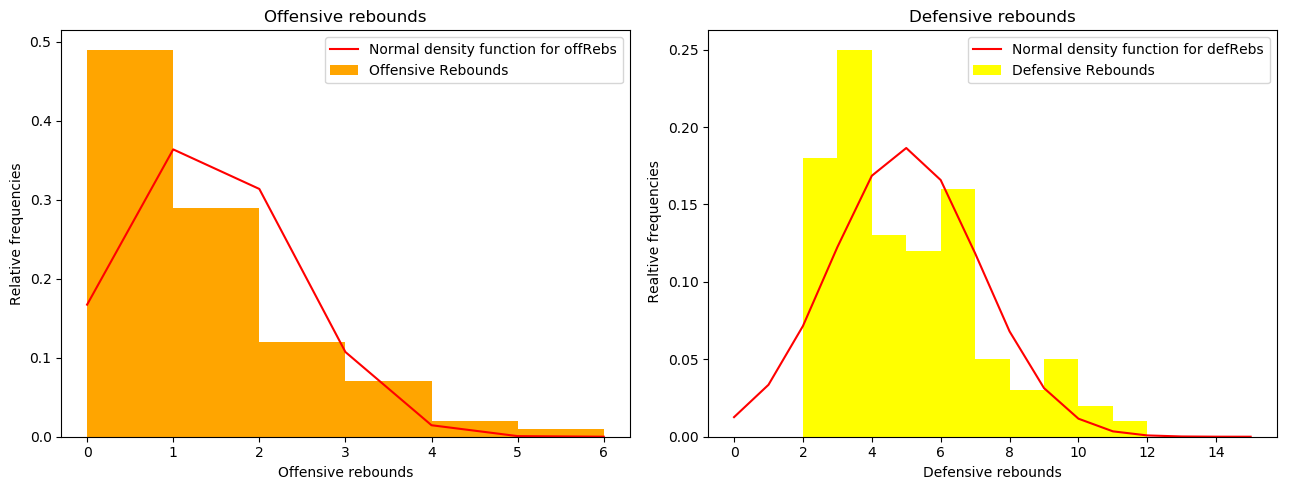

In [47]:
from scipy.stats import norm
fig, ax = plt.subplots(1,2,figsize=(13,5))


n, bins, patches = ax[0].hist(offRebounds, bins = range(0,7) ,density = True, color = 'orange', label =u'Offensive Rebounds')
fun1 = norm.pdf(bins, offRebounds.mean(), np.sqrt(offRebounds.var()))
ax[0].plot(bins, fun1, color = 'r', linestyle = '-', label=u'Normal density function for offRebs')
ax[0].set_xlabel('Offensive rebounds')
ax[0].set_ylabel('Relative frequencies')
ax[0].set_title('Offensive rebounds')


n, bins, patches = ax[1].hist(defRebounds, bins = range(0,16),density = True, color = 'yellow', label =u'Defensive Rebounds')
fun2 = norm.pdf(bins, defRebounds.mean(), np.sqrt(defRebounds.var()))
ax[1].plot(bins, fun2, color = 'r', linestyle = '-', label=u'Normal density function for defRebs')
ax[1].set_xlabel('Defensive rebounds')
ax[1].set_ylabel(' Realtive frequencies')
ax[1].set_title('Defensive rebounds')

ax[0].legend()
ax[1].legend()
fig.tight_layout();

fig

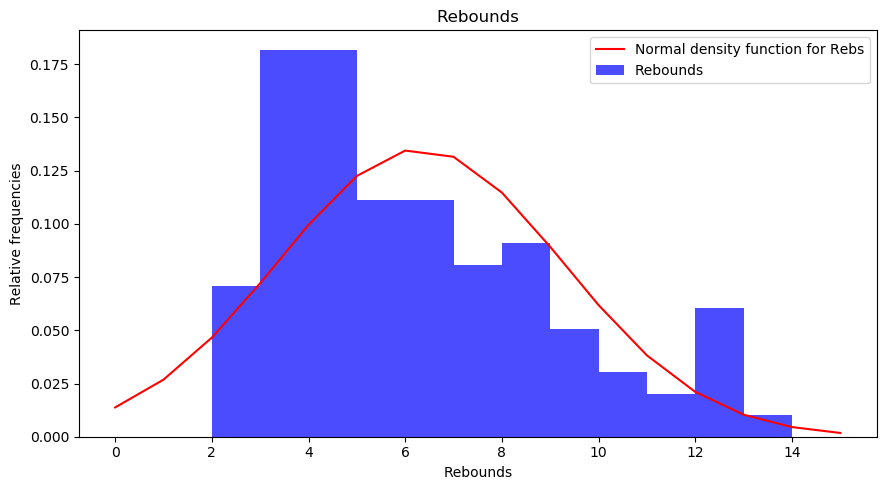

In [48]:

fig, ax3 = plt.subplots(1,1,figsize=(9,5))
n, bins, patches = ax3.hist(rebounds, bins = range(0,16), density = True,alpha = 0.7, color = 'b', label =u'Rebounds')
fun3 = norm.pdf(bins, rebounds.mean(), np.sqrt(rebounds.var()))
ax3.plot(bins, fun3, color = 'r', linestyle = '-', label=u'Normal density function for Rebs')
ax3.set_xlabel('Rebounds')
ax3.set_ylabel('Relative frequencies')
ax3.set_title('Rebounds')

ax3.legend()
fig.tight_layout();


fig

In [49]:
players = players.rename(columns = {"+/-" : "PM"})

In [50]:
pm = players.PM

__$+/-$__ had to be renamed to PM because it couldn't be used
It represents how good has team played when particular player
was on the floor.

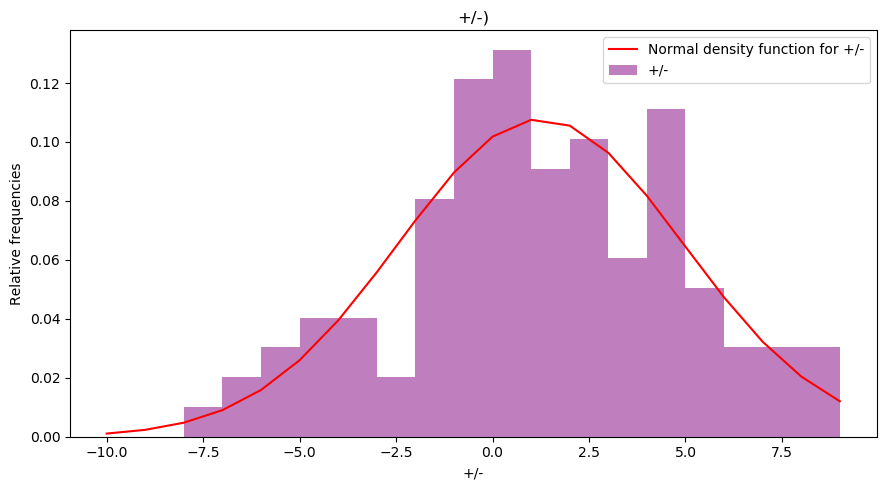

In [51]:
fig, ax4 = plt.subplots(1,1,figsize=(9,5))
n, bins, patches = ax4.hist(pm, bins = range(-10,10), density = True, color = 'purple', alpha = 0.5, label =r'+/-')
fun4 = norm.pdf(bins, pm.mean(), np.sqrt(pm.var()))
ax4.plot(bins, fun4, color = 'r', linestyle = '-', label=r'Normal density function for +/-')
ax4.set_xlabel('+/-')
ax4.set_ylabel('Relative frequencies')
ax4.set_title('+/-)')

ax4.legend()
fig.tight_layout();


fig

### Sample testing

We are going to test if rebounds, offensive rebounds and defensive rebounds 
have normal distribution

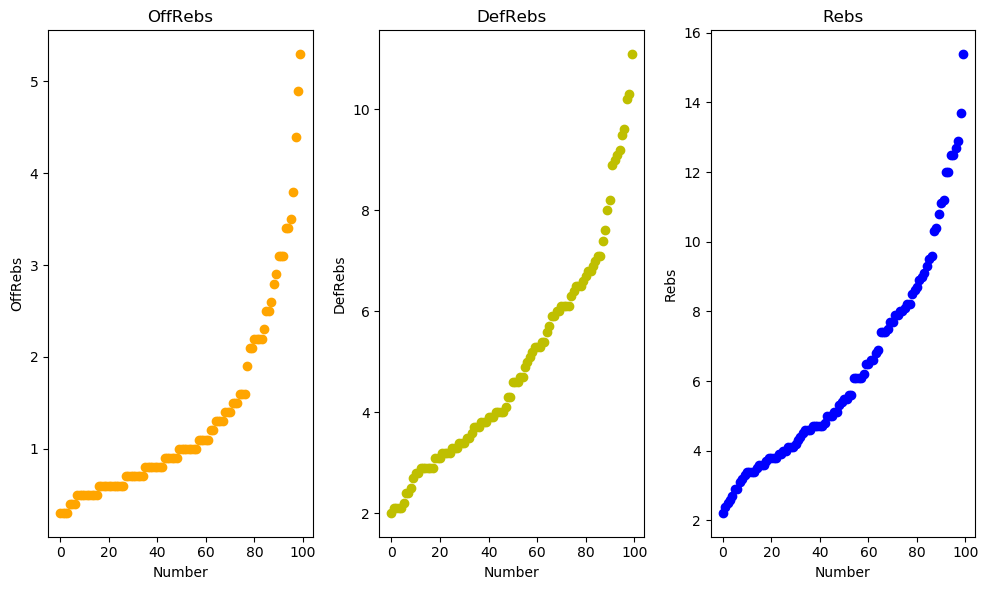

In [52]:
length = np.arange(len(offRebounds))
fig, ax = plt.subplots(1,3, figsize=(10,6))

ax[0].scatter(length, np.sort(offRebounds), color = 'orange')
ax[0].set(xlabel='Number',ylabel='OffRebs',title='OffRebs')

ax[1].scatter(length, np.sort(defRebounds), color = 'y')
ax[1].set(xlabel='Number',ylabel='DefRebs',title='DefRebs')

ax[2].scatter(length, np.sort(rebounds), color = 'b')
ax[2].set(xlabel='Number',ylabel='Rebs',title='Rebs')
fig.tight_layout()

fig

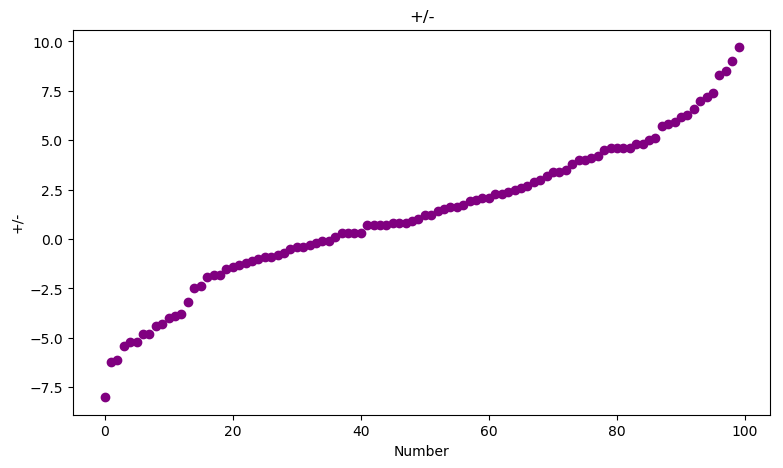

In [53]:
length = np.arange(len(players.PM))
fig, ax = plt.subplots(1,1, figsize=(9,5))

ax.scatter(length, np.sort(pm), color = 'purple')
ax.set(xlabel='Number',ylabel='+/-',title='+/-')
fig

In [54]:
players.columns

Index(['PLAYER', 'TEAM', 'AGE', 'W', 'L', 'MIN', 'PTS', 'FG%', '3PM', '3P%',
       'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP',
       'DD2', 'TD3', 'PM'],
      dtype='object')

In [55]:
points_tov = players[['PTS','TOV']]
points_fp = players[['PTS','FP']]
reb_blk = players[['REB','BLK']]

In [56]:
ast_tov = players[['AST','TOV']]

In [57]:
type(points_fp)

pandas.core.frame.DataFrame

In [58]:
points_fp[:10]

,PTS,FP
0,36.2,58.7
1,28.1,49.2
2,27.7,56.2
3,27.6,53.8
4,27.6,44.4
5,27.4,52.0
6,26.8,45.2
7,26.6,40.8
8,26.2,45.3
9,25.9,56.1


In [59]:
points_fp['PTS'].head(3)

0    36.2
1    28.1
2    27.7
Name: PTS, dtype: float64

In [60]:
np.sort(points_fp['PTS'])

array([13.6, 13.7, 13.7, 13.8, 13.9, 13.9, 14. , 14.1, 14.1, 14.1, 14.3,
       14.3, 14.4, 14.5, 14.5, 14.6, 14.7, 14.7, 14.8, 15. , 15.1, 15.1,
       15.2, 15.2, 15.3, 15.4, 15.6, 15.6, 15.6, 15.6, 15.7, 15.9, 15.9,
       16. , 16.2, 16.3, 16.3, 16.3, 16.5, 16.6, 16.6, 16.7, 16.9, 16.9,
       17. , 17. , 17.2, 17.3, 17.6, 17.9, 18. , 18. , 18. , 18. , 18.1,
       18.1, 18.2, 18.3, 18.7, 18.7, 18.8, 18.9, 19.1, 19.5, 19.9, 20. ,
       20.1, 20.2, 20.3, 20.7, 20.8, 20.9, 21.1, 21.1, 21.2, 21.2, 21.2,
       21.3, 21.4, 21.4, 21.7, 22.9, 23.5, 23.7, 23.8, 24.3, 24.9, 25.4,
       25.9, 25.9, 25.9, 26.2, 26.6, 26.8, 27.4, 27.6, 27.6, 27.7, 28.1,
       36.2])

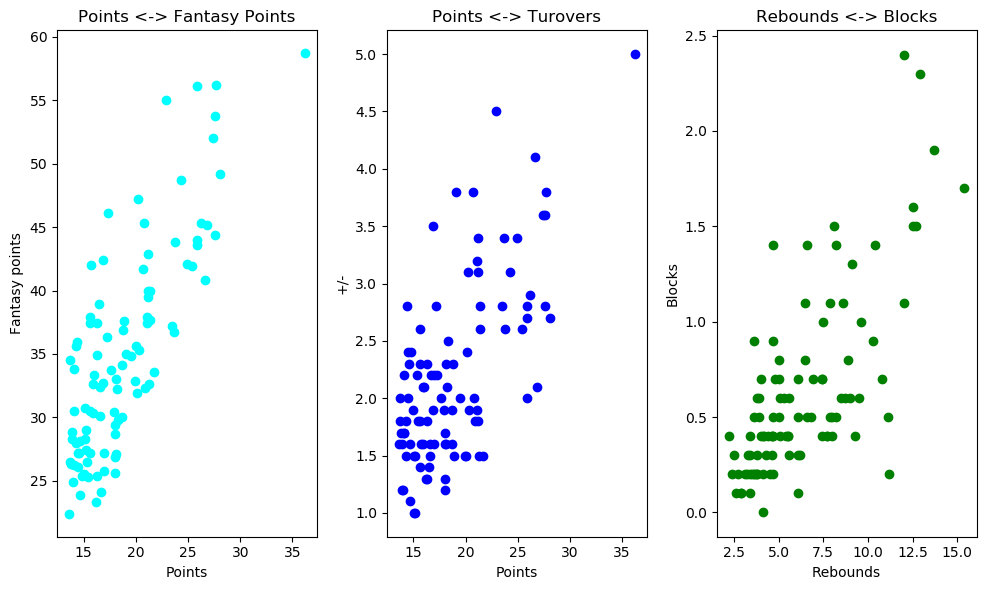

In [61]:
fig, axs = plt.subplots(1,3, figsize=(10,6))

axs[0].scatter(points_fp['PTS'], points_fp['FP'], color = 'cyan')
axs[0].set(xlabel='Points',ylabel='Fantasy points',title='Points <-> Fantasy Points')

axs[1].scatter(points_tov['PTS'], points_tov['TOV'], color = 'b')
axs[1].set(xlabel='Points',ylabel='+/-',title='Points <-> Turovers')

axs[2].scatter(reb_blk['REB'], reb_blk['BLK'], color = 'g')
axs[2].set(xlabel='Rebounds',ylabel='Blocks',title='Rebounds <-> Blocks')
fig.tight_layout()

fig

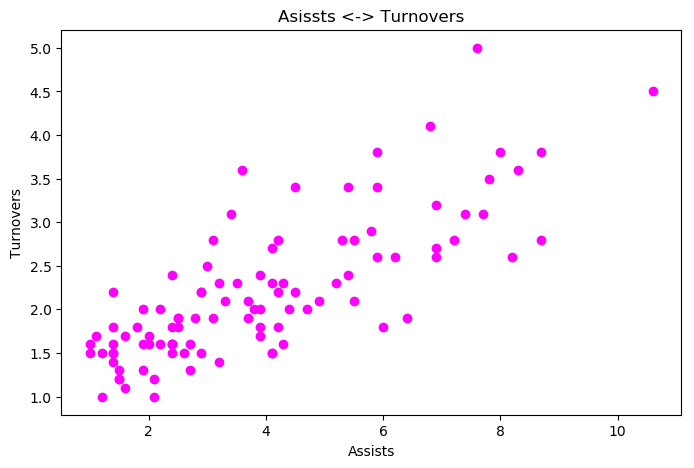

In [62]:
fig, axs = plt.subplots(1,1, figsize=(8,5))

axs.scatter(ast_tov['AST'], ast_tov['TOV'], color = 'magenta')
axs.set(xlabel='Assists',ylabel='Turnovers',title='Asissts <-> Turnovers')
fig

In [63]:
players.loc[players['PM'] == max(players.PM),['PLAYER','PM']]
#best +/-

,PLAYER,PM
4,Stephen Curry,9.7


## Linear regression

__Linear regression__ (which we are going to use)
assumes that target feature $y$ is 
a linear combination of input features $X = \{x_1,\dots,x_p\}$

$$\hat{y}(w,x) = w_0 + w_1 x_1 + \dots + w_p x_p$$

where $w=(w_0,\dots,w_p)$ are parameters of regression.

In two dimensions we can write: $$\hat{y} = \alpha + \beta x$$

We can show that the values $\alpha$ and $\beta$ are as follows:

   __$$\beta = \frac{\sum_{i=1}^{n}{(x_i-x_{mean})(y_i-y_{mean})}}
                  {\sum_{i=1}^{n}{(x_i-x_{mean})^2}}$$__
                  
                  
__$$\alpha = y_{mean} - \beta * x_{mean}$$__


We will use two python modules :

__[statsmodels](https://www.statsmodels.org/stable/index.html)__  — a module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration.

__[scikit_learn](https://scikit-learn.org/stable/)__ — a module that provides simple and efficient tools for data mining and data analysis.

In [64]:
type(ast_tov)

pandas.core.frame.DataFrame

In [65]:
ast_tov.head()

,AST,TOV
0,7.6,5.0
1,4.1,2.7
2,5.9,3.8
3,3.6,3.6
4,5.3,2.8


In [66]:
ast_mean = np.mean(np.asarray(ast_tov['AST']))
ast_mean

3.9199999999999995

In [67]:
tov_mean = np.mean(np.asarray(ast_tov['TOV']))
tov_mean

2.202

In [68]:
ast_tov1 = ast_tov.copy()

In [69]:
ast_tov1.head()

,AST,TOV
0,7.6,5.0
1,4.1,2.7
2,5.9,3.8
3,3.6,3.6
4,5.3,2.8


In [70]:
#calculations for numerator and denominator of beta
ast_tov1['atcov'] = (ast_tov1['AST'] - ast_mean) * (ast_tov1['TOV'] - tov_mean)
ast_tov1['avar'] = (ast_tov['AST'] - ast_mean)**2

In [71]:
ast_tov1.head()

,AST,TOV,atcov,avar
0,7.6,5.0,10.29664,13.5424
1,4.1,2.7,0.08964,0.0324
2,5.9,3.8,3.16404,3.9204
3,3.6,3.6,-0.44736,0.1024
4,5.3,2.8,0.82524,1.9044


In [72]:
#calculate beta and alpha
beta = ast_tov1['atcov'].sum()/ast_tov1['avar'].sum()
alpha = tov_mean - (beta * ast_mean)
print(f'alpha = {alpha}')
print(f'beta = {beta}')

alpha = 1.0670631592432849
beta = 0.28952470427467225


In [73]:
tov_pred = alpha + beta*np.asarray(ast_tov1['AST'])

In [74]:
tov_pred

array([3.26745091, 2.25411445, 2.77525891, 2.10935209, 2.60154409,
       3.4701182 , 2.02249468, 3.03583115, 2.74630644, 2.19620951,
       2.65944903, 3.06478362, 2.77525891, 2.63049656, 2.05144715,
       3.06478362, 2.36992433, 2.28306692, 4.13602502, 1.76192245,
       1.96458974, 2.86211633, 1.9066848 , 1.76192245, 2.77525891,
       3.29640338, 2.92002127, 3.06478362, 1.79087492, 2.16725704,
       3.58592809, 1.87773233, 3.20954597, 2.63049656, 1.35658786,
       1.81982739, 1.6171601 , 3.38326079, 2.25411445, 2.57259162,
       1.47239775, 1.79087492, 1.93563727, 2.48573421, 2.31201939,
       1.76192245, 1.64611257, 1.84877986, 2.31201939, 1.50135022,
       1.79087492, 1.70401751, 1.47239775, 3.15164103, 1.76192245,
       2.36992433, 3.32535585, 1.96458974, 1.9066848 , 1.6171601 ,
       2.25411445, 1.47239775, 1.50135022, 1.58820763, 2.08039962,
       1.6171601 , 2.65944903, 1.70401751, 2.13830457, 1.64611257,
       3.44116573, 1.99354221, 1.99354221, 1.47239775, 2.28306

In [75]:
ast_arr = np.asarray(ast_tov1['AST'])
ast_arr

array([ 7.6,  4.1,  5.9,  3.6,  5.3,  8.3,  3.3,  6.8,  5.8,  3.9,  5.5,
        6.9,  5.9,  5.4,  3.4,  6.9,  4.5,  4.2, 10.6,  2.4,  3.1,  6.2,
        2.9,  2.4,  5.9,  7.7,  6.4,  6.9,  2.5,  3.8,  8.7,  2.8,  7.4,
        5.4,  1. ,  2.6,  1.9,  8. ,  4.1,  5.2,  1.4,  2.5,  3. ,  4.9,
        4.3,  2.4,  2. ,  2.7,  4.3,  1.5,  2.5,  2.2,  1.4,  7.2,  2.4,
        4.5,  7.8,  3.1,  2.9,  1.9,  4.1,  1.4,  1.5,  1.8,  3.5,  1.9,
        5.5,  2.2,  3.7,  2. ,  8.2,  3.2,  3.2,  1.4,  4.2,  4.2,  1.2,
        1.2,  2.1,  1.4,  3.7,  3.9,  1. ,  1.6,  4.1,  2.4,  4.7,  8.7,
        1.4,  6. ,  1.6,  3.9,  2.9,  1.5,  2.1,  2.7,  1.1,  4.4,  3.9,
        2.4])

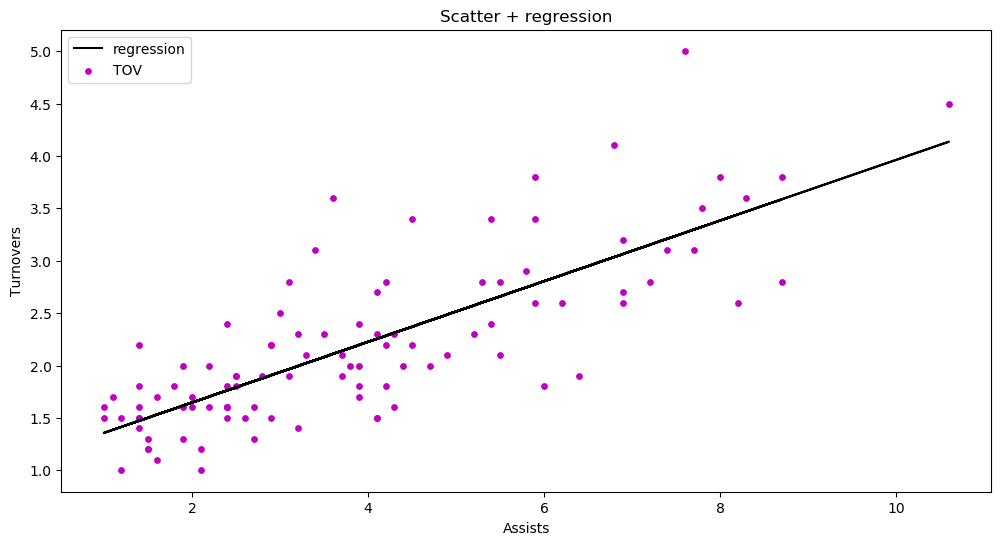

In [76]:
# Plot regression against actual data
fig, axt = plt.subplots(1,1, figsize=(12,6))

axt.scatter(ast_tov1['AST'], ast_tov1['TOV'], color = 'm', s = 15)
axt.plot(ast_tov1['AST'],tov_pred, color = 'black',label = 'regression')
axt.legend(loc='upper left')

axt.set(xlabel='Assists',ylabel='Turnovers',title='Scatter + regression')
fig

In [77]:
print(alpha,beta)

1.0670631592432849 0.28952470427467225


In [78]:
alpha + beta*6.5

2.9489737370286546

The black line is our line od best fit, **$\hat{y}$ = 1.0670631592432849 + 0.28952470427467225$x$**. We can see from this graph that there is a positive linear relationship between assists and turnovers. Using our model, we can predict turnovers from any values of assits!

Exp., for value $ast$ = 6.5, our prediciton would be:
$$\hat{to} = 1.0670631592432849 + 0.28952470427467225(6.5) = 2.9489737370286546$$

### Linear regression with statsmodels

Now that we have learned how to implement a linear regression model from scratch, we will discuss how to use the _ols_ method in the _statsmodels_ library. We will use $POINTS$ and $FANTASY POINTS$ here, just to be different from the other.

In [79]:
players.head()

,PLAYER,TEAM,AGE,W,L,MIN,PTS,FG%,3PM,3P%,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PM
0,James Harden,HOU,29,50,26,36.9,36.2,44.0,4.8,36.5,...,6.5,7.6,5.0,2.0,0.8,3.1,58.7,32,7,4.2
1,Paul George,OKC,28,44,31,36.8,28.1,44.0,3.8,38.9,...,8.2,4.1,2.7,2.2,0.5,2.7,49.2,24,1,6.3
2,Giannis Antetokounmpo,MIL,24,55,16,32.9,27.7,57.7,0.7,25.3,...,12.5,5.9,3.8,1.3,1.5,3.3,56.2,54,5,9.0
3,Joel Embiid,PHI,25,42,21,33.8,27.6,48.3,1.3,30.4,...,13.7,3.6,3.6,0.7,1.9,3.3,53.8,57,2,5.7
4,Stephen Curry,GSW,31,50,17,34.2,27.6,47.0,5.2,43.9,...,5.4,5.3,2.8,1.4,0.4,2.4,44.4,3,0,9.7


In [80]:
import statsmodels.formula.api as smf

# linear regression using 'statsmodels'
model = smf.ols('FP~PTS',data = players)
model = model.fit()

We no longer have to calculate alpha and beta ourselves as this method does it automatically for us! Calling $model.params$ will show us the model’s parameters:

In [81]:
model.params

Intercept    6.662467
PTS          1.505945
dtype: float64

In the notation that we have been using,
α is the intercept and β is the slope i.e. α = 6.662467  and β = 1.505945. Therefore we have the equation for the model: __FP = 6.662467 + 1.505945 PTS__

In [82]:
#just to show how would work on ast, tov
model2 = smf.ols('TOV~AST',data = players)
model2 = model2.fit()
print(model2.params)
print("......")
print("from before:")
print(alpha,beta)

Intercept    1.067063
AST          0.289525
dtype: float64
......
from before:
1.0670631592432849 0.28952470427467225


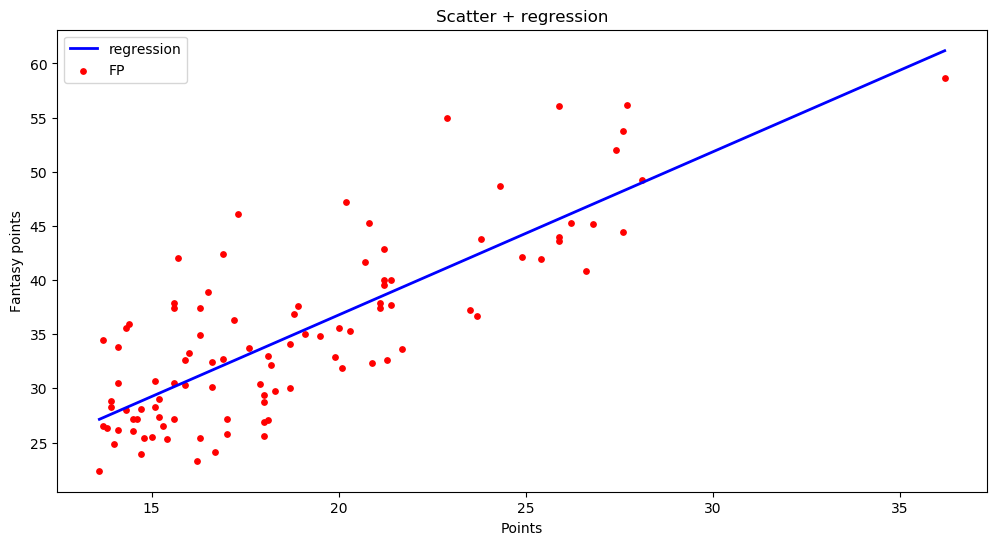

In [83]:
#predicting values
fp_pred = model.predict()

# Plot regression and scatter of table data
fig, axt = plt.subplots(1,1, figsize=(12,6))

axt.scatter(players['PTS'], players['FP'], color = 'r',s = 15)
axt.plot(players['PTS'],fp_pred, color = 'b',linewidth = 2, label = "regression")
axt.legend(loc='upper left')

axt.set(xlabel='Points',ylabel='Fantasy points',title='Scatter + regression')
fig

We can see that there is a positive linear relationship between _points_ and _fantasy points_. In other words, if players scores more points(buckets), chances are he will earn more fantasy points.

Now we can demonstrate prediction on the next example.
Exp.
$points = 30, 25, 16$

In [84]:
new_points = np.array([30,25,16])
model.predict({"PTS":new_points})

0    51.840816
1    44.311091
2    30.757587
dtype: float64

### Linear regression with sckit-learn

Now that we've implemented linear regression using _stats models_ we will try using it with _scikit-learn_

For this model, we will use more than one predictor variables.
It is called __multiple linear regressed model__.
It is modelled by:
$\hat{y}(w,x) = w_0 + w_1 x_1 + \dots + w_p x_p$, where p is the number of predictors.

In our new model:
__$$Fantasy Points = w_0 + w_1Points + w_2Asissts + w_3Rebounds$$__

In [85]:
players.head()

,PLAYER,TEAM,AGE,W,L,MIN,PTS,FG%,3PM,3P%,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PM
0,James Harden,HOU,29,50,26,36.9,36.2,44.0,4.8,36.5,...,6.5,7.6,5.0,2.0,0.8,3.1,58.7,32,7,4.2
1,Paul George,OKC,28,44,31,36.8,28.1,44.0,3.8,38.9,...,8.2,4.1,2.7,2.2,0.5,2.7,49.2,24,1,6.3
2,Giannis Antetokounmpo,MIL,24,55,16,32.9,27.7,57.7,0.7,25.3,...,12.5,5.9,3.8,1.3,1.5,3.3,56.2,54,5,9.0
3,Joel Embiid,PHI,25,42,21,33.8,27.6,48.3,1.3,30.4,...,13.7,3.6,3.6,0.7,1.9,3.3,53.8,57,2,5.7
4,Stephen Curry,GSW,31,50,17,34.2,27.6,47.0,5.2,43.9,...,5.4,5.3,2.8,1.4,0.4,2.4,44.4,3,0,9.7


In [86]:
from sklearn.linear_model import LinearRegression


predictors = players[['PTS','AST','REB']]
fant_points = players['FP']
print(predictors.head(3))
print(".....")
print(fant_points.head(3))

    PTS  AST   REB
0  36.2  7.6   6.5
1  28.1  4.1   8.2
2  27.7  5.9  12.5
.....
0    58.7
1    49.2
2    56.2
Name: FP, dtype: float64


In [87]:
lin_model = LinearRegression()
model3 = lin_model.fit(predictors,fant_points)
print(f'alpha = {model3.intercept_}')
print(f'beta = {model3.coef_}')

alpha = 1.0889566310013805
beta = [0.97470459 1.50420369 1.5356248 ]


So our model is:
__$$FantasyPoints = 1.0889566310014018 + 0.97470459Points 
+ 1.50420369Assists + 1.5356248Rebounds$$__

In [88]:
print("Predictions:")
print(model3.predict(predictors))
print(".......")
print("Real values:")
print(np.asarray(players['FP']))

Predictions:
[57.78677213 47.23751416 56.1583856  54.44399641 44.25545686 53.33356389
 43.5385354  43.54074557 45.33215956 50.62769755 42.28504987 43.77668512
 41.47800417 45.30611187 49.08388076 42.3440554  38.17580864 36.60823173
 56.3996862  31.83907186 39.9706021  40.64100907 32.35485435 39.33696851
 42.45180672 41.01318641 36.50325148 37.86960324 33.05247831 45.50628376
 39.88016309 37.2186661  48.49384454 33.25653079 34.37225056 33.91738137
 37.54211878 37.42125564 33.81692    35.83476104 35.24244086 31.52237813
 31.27034822 32.64880246 34.5664969  27.56232293 27.93810835 26.38048878
 29.24790213 27.03244402 29.6676771  38.75200332 43.70585314 34.51951644
 26.49014788 28.26691331 42.96131375 32.8203068  26.18202595 30.26216355
 28.96453728 38.77990251 26.45038358 35.50114355 34.67991528 23.1155326
 32.02122449 29.26331904 33.51593682 39.20978601 35.69269262 28.01811168
 37.07829799 31.60660671 26.40968734 27.84784168 24.92694742 29.07313437
 27.41176012 30.50500449 26.18907853 26

Like before we can predict on new data.
Exp.

$points = 25$, $asissts = 8$, $rebounds = 6$

$points = 17$, $asissts = 2$, $rebounds = 13$

$points = 20$, $asissts = 21$, $rebounds = 20$

In [89]:
new_data = [[25,8,6],[17,2,13],[20,17,14]]
model3.predict(new_data)

array([46.70394977, 40.63046446, 67.65325843])

That is enough of linear regression.

##  Statistic stuff

In [90]:
players.columns #to remember what we got

Index(['PLAYER', 'TEAM', 'AGE', 'W', 'L', 'MIN', 'PTS', 'FG%', '3PM', '3P%',
       'FT%', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP',
       'DD2', 'TD3', 'PM'],
      dtype='object')

In this section we will estimate some correlation.

First to determine if there is __statistically significant__ correlation between the variables. For that purpose we use __$\chi^2$test__ of the independency of variables in a **contigency table**.

In [91]:
players.corr() #checking the correlation table
#(fp,pts),(reb,blk),(ast,tov) look like some positively correlated vars

,AGE,W,L,MIN,PTS,FG%,3PM,3P%,FT%,OREB,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PM
AGE,1.000000,0.225769,-0.341666,0.052006,0.101486,-0.195932,0.277344,0.150621,0.235840,-0.249425,...,-0.139654,0.222450,-0.045186,0.097512,-0.125547,-0.305520,0.080797,-0.116401,0.081486,0.371145
W,0.225769,1.000000,-0.177634,0.237334,0.176851,0.150791,0.104817,-0.078734,0.064919,0.118721,...,0.121135,0.145691,0.091202,-0.002257,0.137803,-0.004819,0.216498,0.255537,0.164073,0.771704
L,-0.341666,-0.177634,1.000000,0.082139,-0.025175,-0.181643,0.034817,-0.032497,0.014218,-0.005432,...,-0.154203,-0.090750,0.039255,-0.264481,-0.124659,-0.099759,-0.182049,0.002772,-0.063606,-0.601672
MIN,0.052006,0.237334,0.082139,1.000000,0.673491,-0.075306,0.354782,-0.069021,0.026213,-0.020026,...,0.102248,0.454946,0.473963,0.410144,0.050901,0.019039,0.611074,0.238588,0.261331,0.226164
PTS,0.101486,0.176851,-0.025175,0.673491,1.000000,0.011598,0.454545,0.144258,0.247413,-0.015743,...,0.197154,0.445426,0.660367,0.311765,0.128987,0.071228,0.802624,0.299578,0.266954,0.263507
FG%,-0.195932,0.150791,-0.181643,-0.075306,0.011598,1.000000,-0.581438,-0.311070,-0.392990,0.693220,...,0.596333,-0.275796,-0.064875,-0.056898,0.593155,0.399291,0.252885,0.505297,-0.013091,0.203214
3PM,0.277344,0.104817,0.034817,0.354782,0.454545,-0.581438,1.000000,0.566385,0.600358,-0.569263,...,-0.423934,0.222464,0.168678,0.100566,-0.472604,-0.254756,0.066157,-0.360971,0.005912,0.153558
3P%,0.150621,-0.078734,-0.032497,-0.069021,0.144258,-0.311070,0.566385,1.000000,0.650568,-0.510675,...,-0.368608,-0.054364,-0.080330,-0.154912,-0.444083,-0.172172,-0.195406,-0.452311,-0.125557,0.033770
FT%,0.235840,0.064919,0.014218,0.026213,0.247413,-0.392990,0.600358,0.650568,1.000000,-0.494956,...,-0.363302,-0.018213,-0.139728,-0.193267,-0.397809,-0.272747,-0.115607,-0.395642,-0.227326,0.094608
OREB,-0.249425,0.118721,-0.005432,-0.020026,-0.015743,0.693220,-0.569263,-0.510675,-0.494956,1.000000,...,0.843951,-0.294286,-0.022052,-0.021291,0.710424,0.467198,0.361182,0.767871,0.071913,0.139421


In [92]:
#creating a cont table 
#pd.crosstab(players['REB'],players['REB']) we get a ridiculous table
#we need to 'binarize' our table first, if that's even a word

ps = players[['REB','BLK']].copy()
ps.tail()

,REB,BLK
95,6.8,0.5
96,4.7,1.4
97,7.9,1.1
98,3.8,0.3
99,3.8,0.2


In [93]:
#to 'binarize' we need medians
reb_median = players['REB'].median()
blk_median = players['BLK'].median()
print(f'reb_median = {reb_median}')
print(f'blk_median = {blk_median}')

reb_median = 5.45
blk_median = 0.5


In [94]:
ps['boolReb'] = (ps['REB'] > reb_median)
ps['boolBlk'] = (ps['BLK'] > blk_median)
ps.tail()

,REB,BLK,boolReb,boolBlk
95,6.8,0.5,True,False
96,4.7,1.4,False,True
97,7.9,1.1,True,True
98,3.8,0.3,False,False
99,3.8,0.2,False,False


In [95]:
pd.crosstab(ps['boolReb'],ps['boolBlk'])

boolBlk,False,True
boolReb,,
False,39,11
True,19,31


In [96]:
import scipy.stats as st #if it's not already imported
cont_tab = st.chi2_contingency(pd.crosstab(ps['boolReb'],ps['boolBlk']))
cont_tab #(chi2,p-value,deg of freedom, expected freqencies table)

(14.819376026272579, 0.00011831364339490305, 1, array([[29., 21.],
        [29., 21.]]))

In [97]:
?st.chi2_contingency

What are we actually getting from **$\chi^2$ independency test**?

We are testing the hypotheses:<br/>
__$H_0$__: REBs and BLKs are independent features.<br/>
__$H_1$__: REBs and BLKs are not independent features.

With _p-value_ we can conclude next:
- if _$p$_ $\leq$ $\alpha$, then we can discard $H_0$ in benefit of $H_1$, where $\alpha$ is level of significance.
- if _$p$_ > $\alpha$, then we cannot discard $H_0$ in benefit of $H_1$, where $\alpha$ is level of significance.

We will test for:<br/>
$\alpha$ = 0.01<br/>


In [98]:
pVal = cont_tab[1]
print(pVal < 0.01)

True


The _p-value_ is lower than 0.01, so we can discard the $H_0$ hypothesis and conclude that there is a statistically significant correlation between $REBs$ and $BLKs$.

Now we can try to pick some vars that are independent.

In [99]:
players.corr()

,AGE,W,L,MIN,PTS,FG%,3PM,3P%,FT%,OREB,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PM
AGE,1.000000,0.225769,-0.341666,0.052006,0.101486,-0.195932,0.277344,0.150621,0.235840,-0.249425,...,-0.139654,0.222450,-0.045186,0.097512,-0.125547,-0.305520,0.080797,-0.116401,0.081486,0.371145
W,0.225769,1.000000,-0.177634,0.237334,0.176851,0.150791,0.104817,-0.078734,0.064919,0.118721,...,0.121135,0.145691,0.091202,-0.002257,0.137803,-0.004819,0.216498,0.255537,0.164073,0.771704
L,-0.341666,-0.177634,1.000000,0.082139,-0.025175,-0.181643,0.034817,-0.032497,0.014218,-0.005432,...,-0.154203,-0.090750,0.039255,-0.264481,-0.124659,-0.099759,-0.182049,0.002772,-0.063606,-0.601672
MIN,0.052006,0.237334,0.082139,1.000000,0.673491,-0.075306,0.354782,-0.069021,0.026213,-0.020026,...,0.102248,0.454946,0.473963,0.410144,0.050901,0.019039,0.611074,0.238588,0.261331,0.226164
PTS,0.101486,0.176851,-0.025175,0.673491,1.000000,0.011598,0.454545,0.144258,0.247413,-0.015743,...,0.197154,0.445426,0.660367,0.311765,0.128987,0.071228,0.802624,0.299578,0.266954,0.263507
FG%,-0.195932,0.150791,-0.181643,-0.075306,0.011598,1.000000,-0.581438,-0.311070,-0.392990,0.693220,...,0.596333,-0.275796,-0.064875,-0.056898,0.593155,0.399291,0.252885,0.505297,-0.013091,0.203214
3PM,0.277344,0.104817,0.034817,0.354782,0.454545,-0.581438,1.000000,0.566385,0.600358,-0.569263,...,-0.423934,0.222464,0.168678,0.100566,-0.472604,-0.254756,0.066157,-0.360971,0.005912,0.153558
3P%,0.150621,-0.078734,-0.032497,-0.069021,0.144258,-0.311070,0.566385,1.000000,0.650568,-0.510675,...,-0.368608,-0.054364,-0.080330,-0.154912,-0.444083,-0.172172,-0.195406,-0.452311,-0.125557,0.033770
FT%,0.235840,0.064919,0.014218,0.026213,0.247413,-0.392990,0.600358,0.650568,1.000000,-0.494956,...,-0.363302,-0.018213,-0.139728,-0.193267,-0.397809,-0.272747,-0.115607,-0.395642,-0.227326,0.094608
OREB,-0.249425,0.118721,-0.005432,-0.020026,-0.015743,0.693220,-0.569263,-0.510675,-0.494956,1.000000,...,0.843951,-0.294286,-0.022052,-0.021291,0.710424,0.467198,0.361182,0.767871,0.071913,0.139421


In [100]:
ps2 = players[['MIN','PF']].copy()
ps2.head(2)

,MIN,PF
0,36.9,3.1
1,36.8,2.7


In [101]:
ps2['boolMin'] = (ps2['MIN'] > ps2['MIN'].mean())
ps2['boolPF'] = (ps2['PF'] > ps2['PF'].mean())
pd.crosstab(ps2['boolMin'],ps2['boolPF'])

boolPF,False,True
boolMin,,
False,24,17
True,33,26


In [102]:
cont_table2 = st.chi2_contingency(_)
cont_table2[1] < .1

False

With $\alpha$ = 0.1 we cannot discard __$H_0$__ 

#### Time for a short break with Jeremy Lamb.
__Clips below are property of the NBA. No copyright infrigement was intended.__

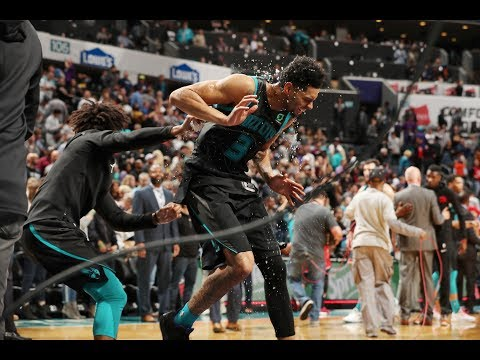

In [105]:
from IPython.display import YouTubeVideo
YouTubeVideo('3IvlkAZhBTg',height = 300, width = 500)
#aJ3_icyho7g


In [106]:
players.describe()

,AGE,W,L,MIN,PTS,FG%,3PM,3P%,FT%,OREB,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PM
count,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,26.32000,34.810000,31.400000,31.205000,18.845000,47.563000,1.666000,33.152000,79.261000,1.340000,...,6.309000,3.920000,2.202000,1.03000,0.625000,2.403000,35.042000,15.260000,1.040000,1.247000
std,3.72781,13.106938,11.212367,3.258505,4.433741,5.805825,1.000325,11.071553,8.139589,1.044853,...,2.966415,2.175019,0.801385,0.45405,0.479135,0.582654,8.318923,16.767947,3.648495,3.702182
min,19.00000,1.000000,1.000000,22.300000,13.600000,38.400000,0.000000,0.000000,50.000000,0.300000,...,2.200000,1.000000,1.000000,0.20000,0.000000,1.100000,22.400000,0.000000,0.000000,-8.000000
25%,24.00000,25.000000,24.500000,28.175000,15.375000,43.475000,1.075000,32.450000,74.900000,0.600000,...,3.975000,2.200000,1.600000,0.70000,0.300000,2.000000,28.250000,2.000000,0.000000,-0.925000
50%,26.00000,38.000000,31.000000,31.600000,17.950000,46.300000,1.750000,35.350000,81.000000,1.000000,...,5.450000,3.550000,2.000000,0.90000,0.500000,2.350000,33.650000,10.000000,0.000000,1.100000
75%,29.00000,44.250000,39.000000,33.825000,21.200000,50.525000,2.225000,37.325000,84.975000,1.600000,...,8.025000,5.400000,2.625000,1.30000,0.725000,2.800000,40.000000,21.000000,1.000000,4.000000
max,37.00000,58.000000,61.000000,37.300000,36.200000,66.900000,5.200000,75.000000,92.800000,5.300000,...,15.400000,10.600000,5.000000,2.80000,2.400000,3.800000,58.700000,66.000000,31.000000,9.700000


In [107]:
np.asarray(players.iloc[1])

array(['Paul George', 'OKC', 28, 44, 31, 36.8, 28.1, 44.0, 3.8, 38.9,
       83.7, 1.4, 6.8, 8.2, 4.1, 2.7, 2.2, 0.5, 2.7, 49.2, 24, 1, 6.3],
      dtype=object)

## Fantasy points - algorithm implemantation

In [108]:
plyrs =  np.genfromtxt('players.csv', skip_header=1, delimiter=',')

In [109]:
plyrs.ravel().shape

(2900,)

In [110]:
plyrs[np.logical_not(np.isnan(plyrs))]

array([29. , 76. , 50. , ...,  0. ,  0. , -1.2])

In [111]:
plyrs.shape

(100, 29)

In [112]:
plyrs = plyrs[np.logical_not(np.isnan(plyrs))]

In [113]:
plyrs.shape

(2700,)

In [114]:
plyrs = plyrs.reshape(100,27)
plyrs[0][5]

36.2

In [115]:
players.head()

,PLAYER,TEAM,AGE,W,L,MIN,PTS,FG%,3PM,3P%,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,PM
0,James Harden,HOU,29,50,26,36.9,36.2,44.0,4.8,36.5,...,6.5,7.6,5.0,2.0,0.8,3.1,58.7,32,7,4.2
1,Paul George,OKC,28,44,31,36.8,28.1,44.0,3.8,38.9,...,8.2,4.1,2.7,2.2,0.5,2.7,49.2,24,1,6.3
2,Giannis Antetokounmpo,MIL,24,55,16,32.9,27.7,57.7,0.7,25.3,...,12.5,5.9,3.8,1.3,1.5,3.3,56.2,54,5,9.0
3,Joel Embiid,PHI,25,42,21,33.8,27.6,48.3,1.3,30.4,...,13.7,3.6,3.6,0.7,1.9,3.3,53.8,57,2,5.7
4,Stephen Curry,GSW,31,50,17,34.2,27.6,47.0,5.2,43.9,...,5.4,5.3,2.8,1.4,0.4,2.4,44.4,3,0,9.7


In [116]:
players_novo = pd.read_csv('players.csv') # trebamo sa maknutim redovimaŽ

In [117]:
players_novo.columns
#kad se maknu 'PLAYER' i 'TEAM' imamo:
#pts = 5, fgm = 6, fga = 7, ftm = 12, fta = 13, oreb = 15, dreb = 16
#ast = 18, tov = 19, stl = 20, blk = 21, pf = 22

Index(['PLAYER', 'TEAM', 'AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-'],
      dtype='object')

In [118]:
import sympy as sp
sp.init_printing()

In [119]:
sPts, sFgm, sFga, sFtm, sFta, sOreb, sDreb, sAst, sTov, sStl, sBlk, sPf = sp.symbols('Pts, Fgm, Fga, Ftm, Fta, Oreb, Dreb, Ast, Tov, Stl, Blk, Pf')

In [120]:
gmsc = sp.Symbol('GmSc')

In [121]:
gmsc

In [122]:
expr = sPts + (sp.S(0.4) * sFgm) - (sp.S(0.7) * sFga)

In [123]:
expr += -(sp.S(0.4) * (sFta - sFtm)) + (sp.S(0.7) * sOreb)
expr += (sp.S(0.3) * sDreb) + sStl + (sp.S(0.7) * sAst)
expr += (sp.S(0.7) * sBlk) - (sp.S(0.4) * sPf) -sTov

In [124]:
expr

In [125]:
sp.srepr(expr)

"Add(Mul(Float('0.69999999999999996', precision=53), Symbol('Ast')), Mul(Float('0.69999999999999996', precision=53), Symbol('Blk')), Mul(Float('0.29999999999999999', precision=53), Symbol('Dreb')), Mul(Integer(-1), Float('0.69999999999999996', precision=53), Symbol('Fga')), Mul(Float('0.40000000000000002', precision=53), Symbol('Fgm')), Mul(Integer(-1), Float('0.40000000000000002', precision=53), Symbol('Fta')), Mul(Float('0.40000000000000002', precision=53), Symbol('Ftm')), Mul(Float('0.69999999999999996', precision=53), Symbol('Oreb')), Mul(Integer(-1), Float('0.40000000000000002', precision=53), Symbol('Pf')), Symbol('Pts'), Symbol('Stl'), Mul(Integer(-1), Symbol('Tov')))"

In [126]:
eq = sp.Eq(gmsc,expr)
eq

In [127]:
#Game Score = Points Scored  
#+ (0.4 x Field Goals) – (0.7 x Field Goal Attempts)  
#- (0.4 x (Free Throw Attempts – Free Throws)) + (0.7 xOffensive Rebounds)
#+ (0.3 x Defensive Rebounds) + Steals + (0.7 x Assists)
#+ (0.7 x Blocks) – (0.4 x Personal Fouls) – Turnovers
def gameScore(pfp):
    GmSc = pfp[5] + (0.4 * pfp[6]) - (0.7 * pfp[7])
    GmSc = GmSc - (0.4 * (pfp[13] - pfp[12])) + (0.7 * pfp[15])
    GmSc = GmSc + (0.3 * pfp[16]) + pfp[20] + (0.7 * pfp[18])
    GmSc = GmSc + (0.7 * pfp[21]) - (0.4 * pfp[22]) - pfp[19]
    return GmSc
    

In [128]:
players_novo[['PTS','FGM','FGA','FTM','FTA','OREB','DREB','STL','AST','BLK','PF','TOV']].head()

,PTS,FGM,FGA,FTM,FTA,OREB,DREB,STL,AST,BLK,PF,TOV
0,36.2,10.8,24.6,9.7,11.0,0.9,5.6,2.0,7.6,0.8,3.1,5.0
1,28.1,9.2,20.9,5.9,7.0,1.4,6.8,2.2,4.1,0.5,2.7,2.7
2,27.7,10.0,17.4,6.9,9.5,2.2,10.3,1.3,5.9,1.5,3.3,3.8
3,27.6,9.1,18.8,8.3,10.2,2.5,11.1,0.7,3.6,1.9,3.3,3.6
4,27.6,9.2,19.6,3.9,4.3,0.7,4.7,1.4,5.3,0.4,2.4,2.8


In [129]:
type(gameScore(plyrs[0]))

numpy.float64

In [130]:
len(plyrs)

In [131]:
allPlyrs = np.empty(0)
type(allPlyrs)

numpy.ndarray

In [132]:
for i in range(len(plyrs)):
    allPlyrs = np.append(allPlyrs, gameScore(plyrs[i]))
    
allPlyrs

array([26.73, 21.37, 24.47, 22.03, 20.93, 22.68, 21.36, 18.09, 20.98,
       24.14, 19.25, 20.07, 18.31, 17.98, 20.35, 19.27, 15.83, 14.97,
       19.06, 14.46, 15.99, 16.63, 14.13, 17.21, 15.73, 17.52, 16.97,
       14.54, 14.15, 18.6 , 15.84, 15.17, 19.57, 14.52, 18.1 , 15.61,
       15.66, 14.08, 16.74, 14.12, 13.27, 12.11, 11.79, 13.09, 13.17,
       10.84, 12.53, 12.04, 13.08, 12.48, 10.93, 12.97, 17.07, 14.13,
       11.01, 11.78, 16.63, 14.02,  9.36, 14.23, 11.95, 16.95, 10.56,
       14.42, 13.8 ,  9.46, 13.95, 11.67, 12.19, 17.45, 14.6 , 12.48,
       14.39, 12.63, 10.29,  9.61, 10.44, 11.71, 11.53, 12.12,  9.68,
        9.79, 11.41,  9.66, 10.09, 10.11, 10.07, 13.75, 10.06, 12.16,
       14.1 , 10.02, 12.56,  9.94, 11.36, 11.23,  9.74, 12.18,  9.75,
        9.8 ])

In [133]:
players_novo.iloc[0]

PLAYER    James Harden
TEAM               HOU
AGE                 29
GP                  76
W                   50
L                   26
MIN               36.9
PTS               36.2
FGM               10.8
FGA               24.6
FG%                 44
3PM                4.8
3PA               13.3
3P%               36.5
FTM                9.7
FTA                 11
FT%               87.9
OREB               0.9
DREB               5.6
REB                6.5
AST                7.6
TOV                  5
STL                  2
BLK                0.8
PF                 3.1
FP                58.7
DD2                 32
TD3                  7
+/-                4.2
Name: 0, dtype: object

In [134]:
eq.subs({sPts: 36.2, sFgm: 10.8, sFga: 24.6, sAst: 7.6, sTov: 5, sOreb: 0.9, sDreb: 5.6, sFtm: 9.7, sFta: 11, sBlk: 0.8, sPf: 3.1, sStl: 2})

In [135]:
print(f'GmSc = {gameScore(plyrs[0])}')

GmSc = 26.730000000000004


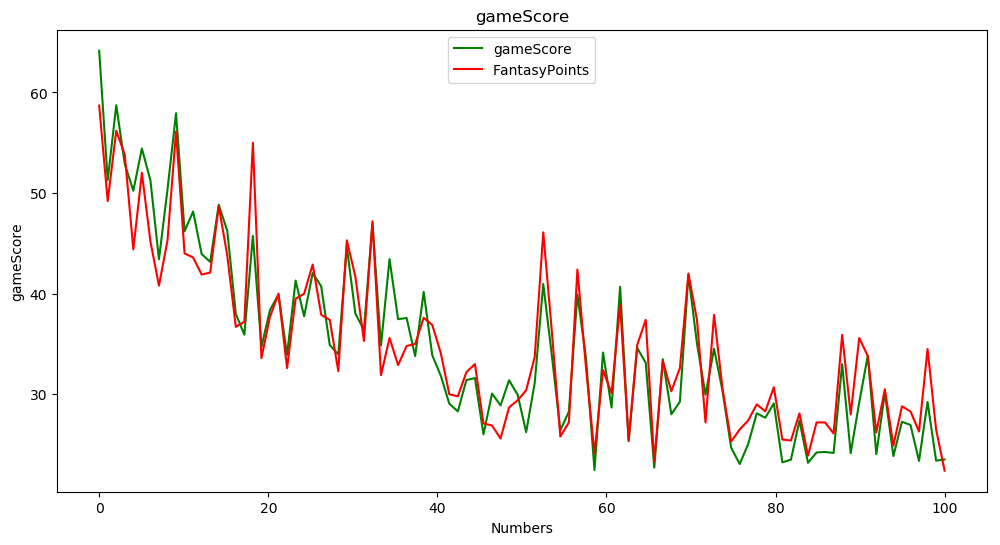

In [136]:
fig, axt = plt.subplots(1,1, figsize=(12,6))

axt.plot(np.linspace(0,100,100), allPlyrs*2.4, color = 'g',label = 'gameScore')
axt.plot(np.linspace(0,100,100), players['FP'], color = 'r', label = 'FantasyPoints')
axt.legend(loc='upper center')
axt.set(xlabel='Numbers',ylabel='gameScore',title='gameScore')
fig


## Polynomial Regression

In [137]:
players_novo.columns

Index(['PLAYER', 'TEAM', 'AGE', 'GP', 'W', 'L', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-'],
      dtype='object')

We did linear regression, now we can try using polynomial.
First we scatter some points on the plot. As variables we will use ordered numberer 0-99 (player index), and calculated gamescore points from the function earlier. Than we add a degree w polynomial, where w is value of widget below. 

In [138]:
import ipywidgets as widgets
from IPython.display import display

w = widgets.IntSlider(2,1,15)
display(w)

IntSlider(value=2, max=15, min=1)

In [139]:
w.value

1.9563820233383735
0.7444804356094015


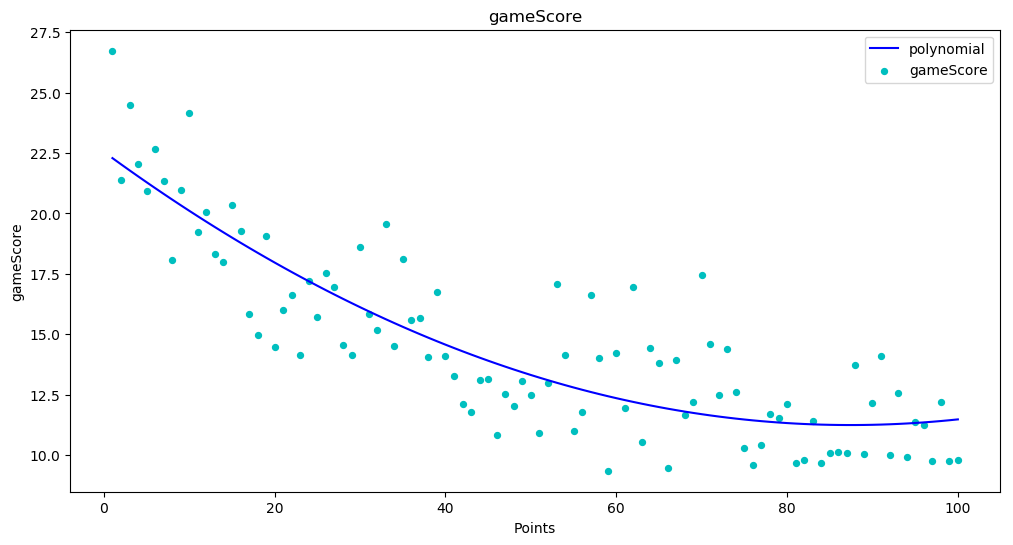

In [140]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import operator

figure, axd = plt.subplots(1,1, figsize = (12,6))
axd.scatter(np.sort(np.linspace(1,100,100)),allPlyrs, color ='c',s = 18,  label = 'gameScore')
#axd.scatter(players_novo['PTS'],allPlyrs, color ='m',s = 18,  label = 'gameScore')
axd.set(xlabel='Points',ylabel='gameScore',title='gameScore')


x = np.sort(np.linspace(1,100,100))
x = x[:,np.newaxis]

allPlyrs_c = allPlyrs.copy()
allPlyrs_c = allPlyrs_c[:,np.newaxis]

polynomial_features = PolynomialFeatures(degree=w.value)
x_polynomial = polynomial_features.fit_transform(x)

newModel2 = LinearRegression()
newModel2.fit(x_polynomial,allPlyrs_c)
allPlyrs_c_pp = newModel2.predict(x_polynomial)

rmse = np.sqrt(mean_squared_error(allPlyrs_c,allPlyrs_c_pp))
r2 = r2_score(allPlyrs_c,allPlyrs_c_pp)
print(rmse)
print(r2)

sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(x ,allPlyrs_c_pp), key=sort_axis)
x, allPlyrs_c_pp = zip(*sorted_zip)
axd.plot(x, allPlyrs_c_pp, color = 'b', label ='polynomial')

axd.legend(loc = 'best')

figure

## Teams (playoff predictions)

There is gonna be a lot of code below, so i will use some markdown cells to explain what is being done.

First we extract team info (columns TEAM,W,L)

In [141]:
#teamList = players[['TEAM','W','L']].copy()

In [142]:
teamList = pd.DataFrame(players[['TEAM','W','L']])
teamList.head()

,TEAM,W,L
0,HOU,50,26
1,OKC,44,31
2,MIL,55,16
3,PHI,42,21
4,GSW,50,17


In [143]:

#drop later

In [144]:
len(teamList[['TEAM','W','L']].drop_duplicates(['TEAM']))

In [145]:
#teamList = teamList[['TEAM','W','L']].drop_duplicates(['TEAM'])

In [146]:
teamList['TEAM']

0     HOU
1     OKC
2     MIL
3     PHI
4     GSW
5     LAL
6     TOR
7     PHX
8     GSW
9     NOP
10    WAS
11    POR
12    CHA
13    DET
14    MIN
15    BOS
16    CHI
17    UTA
18    OKC
19    GSW
20    NOP
21    SAS
22    POR
23    SAS
24    DAL
25    NOP
26    MEM
27    BKN
28    SAC
29    ORL
     ... 
70    HOU
71    MIL
72    POR
73    MEM
74    DET
75    OKC
76    PHX
77    MIL
78    CHA
79    TOR
80    ORL
81    NYK
82    SAC
83    ORL
84    MIA
85    WAS
86    MIA
87    TOR
88    WAS
89    CHI
90    OKC
91    SAC
92    IND
93    BOS
94    CHI
95    SAS
96    MEM
97    TOR
98    BKN
99    BKN
Name: TEAM, Length: 100, dtype: object

In [147]:
arrWest = np.array(['GSW','DEN','POR','HOU','UTA','OKC','SAS','LAC','SAC','LAL','MIN','MEM','NOP','DAL','PHX'])

In [148]:
arrWest

array(['GSW', 'DEN', 'POR', 'HOU', 'UTA', 'OKC', 'SAS', 'LAC', 'SAC',
       'LAL', 'MIN', 'MEM', 'NOP', 'DAL', 'PHX'], dtype='<U3')

In [149]:
teams = np.asarray(teamList)

In [150]:
len(teams)

Here we will split teams in conferences to simulate playoffs.

In [151]:
teams[3,0] in arrWest

False

In [152]:
teams[0][0] in arrWest

True

In [153]:
teamList['TEAM'][0]

'HOU'

In [154]:
teamList.iloc[0]

TEAM    HOU
W        50
L        26
Name: 0, dtype: object

In [155]:
teamList.loc[0,'TEAM']

'HOU'

In [156]:
for i in range(len(teamList)):
    if(teamList.iloc[i][0] in arrWest):
        teamList.loc[i,'CONF'] = 'WEST'
    else:
        teamList.loc[i,'CONF'] = 'EAST'

In [157]:
teamList.head()

,TEAM,W,L,CONF
0,HOU,50,26,WEST
1,OKC,44,31,WEST
2,MIL,55,16,EAST
3,PHI,42,21,EAST
4,GSW,50,17,WEST


Now we add seeds by realtime table(W/L percentage). Data is couple of games behind because it was extracted when those games haven't been played yet.

In [158]:
playoffEast = np.array([['MIL',1],['TOR',2],['PHI',3],['BOS',4],['IND',5],['BKN',6],['ORL',7],['DET',8]])
playoffEast

array([['MIL', '1'],
       ['TOR', '2'],
       ['PHI', '3'],
       ['BOS', '4'],
       ['IND', '5'],
       ['BKN', '6'],
       ['ORL', '7'],
       ['DET', '8']], dtype='<U3')

In [159]:
playoffEast[:,0]

array(['MIL', 'TOR', 'PHI', 'BOS', 'IND', 'BKN', 'ORL', 'DET'],
      dtype='<U3')

In [160]:
playoffEast[0,0]

'MIL'

In [161]:
result = np.where(playoffEast[:,0] == 'DET')
result[0][0]

7

In [162]:
(int)(playoffEast[np.where(playoffEast[:,0] == teamList.iloc[6][0]),1][0][0])

In [163]:
teamList.iloc[6][0]

'TOR'

In [164]:
for i in range(len(teamList)):
    if(teamList.iloc[i][0] in playoffEast[:,0]):
        result = np.where(playoffEast[:,0] == teamList.iloc[i][0])
        #print(result)
        teamList.loc[i,'PS'] = (int)(playoffEast[np.where(playoffEast[:,0] == teamList.iloc[i][0]),1][0][0])
    else:
        teamList.loc[i,'PS'] = '0'

In [165]:
teamList

,TEAM,W,L,CONF,PS
0,HOU,50,26,WEST,0
1,OKC,44,31,WEST,0
2,MIL,55,16,EAST,1
3,PHI,42,21,EAST,3
4,GSW,50,17,WEST,0
5,LAL,28,27,WEST,0
6,TOR,39,19,EAST,2
7,PHX,15,49,WEST,0
8,GSW,53,23,WEST,0
9,NOP,25,31,WEST,0


In [166]:
playoffWest = np.array([['GSW',1],['DEN',2],['POR',3],['HOU',4],['UTA',5],['OKC',6],['SAS',7],['LAC',8]])
playoffWest

array([['GSW', '1'],
       ['DEN', '2'],
       ['POR', '3'],
       ['HOU', '4'],
       ['UTA', '5'],
       ['OKC', '6'],
       ['SAS', '7'],
       ['LAC', '8']], dtype='<U3')

In [167]:
for i in range(len(teamList)):
    if(teamList.iloc[i][0] in playoffWest[:,0]):
        result = np.where(playoffWest[:,0] == teamList.iloc[i][0])
        #print(result)
        teamList.loc[i,'PS'] = (int)(playoffWest[np.where(playoffWest[:,0] == teamList.iloc[i][0]),1][0][0])

In [168]:
teamList

,TEAM,W,L,CONF,PS
0,HOU,50,26,WEST,4
1,OKC,44,31,WEST,6
2,MIL,55,16,EAST,1
3,PHI,42,21,EAST,3
4,GSW,50,17,WEST,1
5,LAL,28,27,WEST,0
6,TOR,39,19,EAST,2
7,PHX,15,49,WEST,0
8,GSW,53,23,WEST,1
9,NOP,25,31,WEST,0


In [169]:
#teamList = teamList[['TEAM','W','L','CONF','PS']].drop_duplicates(['TEAM'])
teamList.head(3)

,TEAM,W,L,CONF,PS
0,HOU,50,26,WEST,4
1,OKC,44,31,WEST,6
2,MIL,55,16,EAST,1


In [170]:
#more analyis to follow


Now we wanna eliminate zeros in teamList['PS'] befor removing the duplicates.

In [171]:
len(teamList)

In [172]:
tL = np.asarray(teamList)

In [173]:
type(teamList['PS'][0])

int

In [174]:
elems = np.where(teamList['PS'] == '0')
elems

(array([ 5,  7,  9, 10, 12, 14, 16, 20, 24, 25, 26, 28, 30, 34, 36, 37, 40,
        41, 42, 45, 48, 49, 50, 51, 53, 54, 58, 60, 62, 63, 73, 76, 78, 81,
        82, 84, 85, 86, 88, 89, 91, 94, 96], dtype=int32),)

In [175]:
tList = teamList[(teamList.T != '0').all()]
tList

,TEAM,W,L,CONF,PS
0,HOU,50,26,WEST,4
1,OKC,44,31,WEST,6
2,MIL,55,16,EAST,1
3,PHI,42,21,EAST,3
4,GSW,50,17,WEST,1
6,TOR,39,19,EAST,2
8,GSW,53,23,WEST,1
11,POR,49,29,WEST,3
13,DET,38,35,EAST,8
15,BOS,37,29,EAST,4


In [176]:
len(tList)

In [177]:
len(tList.drop_duplicates(['TEAM']))

In [178]:
tList = tList.drop_duplicates(['TEAM'])
tList

,TEAM,W,L,CONF,PS
0,HOU,50,26,WEST,4
1,OKC,44,31,WEST,6
2,MIL,55,16,EAST,1
3,PHI,42,21,EAST,3
4,GSW,50,17,WEST,1
6,TOR,39,19,EAST,2
11,POR,49,29,WEST,3
13,DET,38,35,EAST,8
15,BOS,37,29,EAST,4
17,UTA,48,27,WEST,5


In [179]:
westConf = tList.loc[tList['CONF'] == 'WEST']
eastConf = tList.loc[tList['CONF'] == 'EAST']

In [180]:
westConf

,TEAM,W,L,CONF,PS
0,HOU,50,26,WEST,4
1,OKC,44,31,WEST,6
4,GSW,50,17,WEST,1
11,POR,49,29,WEST,3
17,UTA,48,27,WEST,5
21,SAS,42,33,WEST,7
32,DEN,52,26,WEST,2
33,LAC,46,27,WEST,8


In [181]:
eastConf

,TEAM,W,L,CONF,PS
2,MIL,55,16,EAST,1
3,PHI,42,21,EAST,3
6,TOR,39,19,EAST,2
13,DET,38,35,EAST,8
15,BOS,37,29,EAST,4
27,BKN,39,39,EAST,6
29,ORL,40,39,EAST,7
39,IND,25,11,EAST,5


In [182]:
west = westConf.sort_values(by = ['PS'])
east = eastConf.sort_values(by = ['PS'])

In [183]:
west

,TEAM,W,L,CONF,PS
4,GSW,50,17,WEST,1
32,DEN,52,26,WEST,2
11,POR,49,29,WEST,3
0,HOU,50,26,WEST,4
17,UTA,48,27,WEST,5
1,OKC,44,31,WEST,6
21,SAS,42,33,WEST,7
33,LAC,46,27,WEST,8


In [184]:
east

,TEAM,W,L,CONF,PS
2,MIL,55,16,EAST,1
6,TOR,39,19,EAST,2
3,PHI,42,21,EAST,3
15,BOS,37,29,EAST,4
39,IND,25,11,EAST,5
27,BKN,39,39,EAST,6
29,ORL,40,39,EAST,7
13,DET,38,35,EAST,8


In [185]:
west['PERC'] = west['W']/(west['W'] + west['L'])
east['PERC'] = east['W']/(east['W'] + east['L'])
west

,TEAM,W,L,CONF,PS,PERC
4,GSW,50,17,WEST,1,0.746269
32,DEN,52,26,WEST,2,0.666667
11,POR,49,29,WEST,3,0.628205
0,HOU,50,26,WEST,4,0.657895
17,UTA,48,27,WEST,5,0.640000
1,OKC,44,31,WEST,6,0.586667
21,SAS,42,33,WEST,7,0.560000
33,LAC,46,27,WEST,8,0.630137


In [186]:
arrWest = np.asarray(west)
arrEast = np.asarray(east)
arrEast

array([['MIL', 55, 16, 'EAST', 1, 0.7746478873239436],
       ['TOR', 39, 19, 'EAST', 2, 0.6724137931034483],
       ['PHI', 42, 21, 'EAST', 3, 0.6666666666666666],
       ['BOS', 37, 29, 'EAST', 4, 0.5606060606060606],
       ['IND', 25, 11, 'EAST', 5, 0.6944444444444444],
       ['BKN', 39, 39, 'EAST', 6, 0.5],
       ['ORL', 40, 39, 'EAST', 7, 0.5063291139240507],
       ['DET', 38, 35, 'EAST', 8, 0.5205479452054794]], dtype=object)

Now that we have conferences in arrays we can start simulating playoffs. From each conference matchups are 1-8,2-7,3-6,4-5.

In [187]:
import random
samples = 7

def genRand():
    team1rand = np.empty(0)
    team2rand = np.empty(0)
    for i in range(samples):
        team1rand = np.append(team1rand,random.randint(1,100))
        team2rand = np.append(team2rand,random.randint(1,100))

    return team1rand,team2rand

In [188]:
t1, t2 = genRand()

print(f'team1rand = {t1}')
print(f'team2rand = {t2}')

team1rand = [76. 33. 94. 29. 72. 16. 84.]
team2rand = [64. 42. 29. 75. 91. 78. 63.]


In [189]:
arrWest[7]

array(['LAC', 46, 27, 'WEST', 8, 0.6301369863013698], dtype=object)

In [190]:
team1West = arrWest[0]
team2West = arrWest[1]
team3West = arrWest[2]
team4West = arrWest[3]
team5West = arrWest[4]
team6West = arrWest[5]
team7West = arrWest[6]
team8West = arrWest[7]

team1East = arrEast[0]
team2East = arrEast[1]
team3East = arrEast[2]
team4East = arrEast[3]
team5East = arrEast[4]
team6East = arrEast[5]
team7East = arrEast[6]
team8East = arrEast[7]

team5West

array(['UTA', 48, 27, 'WEST', 5, 0.64], dtype=object)

In [191]:
def simulateMatchup(team1,team2):
    t1,t2 = genRand()
    #print(f'team1rand = {t1}')
    #print(f'team2rand = {t2}')
    t1 *= team1[5]
    t2 *= team2[5]
    #print(f'team1rand = {t1}')
    #print(f'team2rand = {t2}')
    #print(np.count_nonzero(t1 > t2))
    #print(np.count_nonzero(t1 < t2))
    if(np.count_nonzero(t1 > t2) > np.count_nonzero(t1 < t2)):
        return team1
    else: return team2

Now simulations.

In [192]:
simulateMatchup(team4West,team5West)

array(['UTA', 48, 27, 'WEST', 5, 0.64], dtype=object)

In [193]:
team21West = simulateMatchup(team1West,team8West)
team22West = simulateMatchup(team2West,team7West)
team23West = simulateMatchup(team3West,team6West)
team24West = simulateMatchup(team4West,team5West)

team21East = simulateMatchup(team1East,team8East)
team22East = simulateMatchup(team2East,team7East)
team23East = simulateMatchup(team3East,team6East)
team24East = simulateMatchup(team4East,team5East)

In [194]:
print(team21West)
print(team22West)
print(team23West)
print(team24West)

print('.........................................')

print(team21East)
print(team22East)
print(team23East)
print(team24East)

['LAC' 46 27 'WEST' 8 0.6301369863013698]
['DEN' 52 26 'WEST' 2 0.6666666666666666]
['POR' 49 29 'WEST' 3 0.6282051282051282]
['UTA' 48 27 'WEST' 5 0.64]
.........................................
['MIL' 55 16 'EAST' 1 0.7746478873239436]
['TOR' 39 19 'EAST' 2 0.6724137931034483]
['PHI' 42 21 'EAST' 3 0.6666666666666666]
['BOS' 37 29 'EAST' 4 0.5606060606060606]


In [195]:
team31West = simulateMatchup(team21West,team24West)
team32West = simulateMatchup(team22West,team23West)

team31East = simulateMatchup(team21East,team24East)
team32East = simulateMatchup(team22East,team23East)

In [196]:
print(team31West)
print(team32West)

print('.........................................')

print(team31East)
print(team32East)

['UTA' 48 27 'WEST' 5 0.64]
['POR' 49 29 'WEST' 3 0.6282051282051282]
.........................................
['MIL' 55 16 'EAST' 1 0.7746478873239436]
['PHI' 42 21 'EAST' 3 0.6666666666666666]


In [197]:
westChamp = simulateMatchup(team31West,team32West)
eastChamp = simulateMatchup(team31East,team32East)

In [198]:
print(westChamp)
print('.........................................')
print(eastChamp)

['POR' 49 29 'WEST' 3 0.6282051282051282]
.........................................
['MIL' 55 16 'EAST' 1 0.7746478873239436]


In [199]:
NBAchamp = simulateMatchup(westChamp,eastChamp)
print(NBAchamp)

['MIL' 55 16 'EAST' 1 0.7746478873239436]


By this random generator **`Milwaukee Bucks`** are simulated champions.
Notebook reader might get different results.

## Outro

Some interesting stuff came into light in this notebook, but everything of that has already been written so i don't have the urge to write a short summary. I'd rather put some pictures in, and write ending riddle.

_I'm easy to waste, yet unstoppable. **What am I?**_

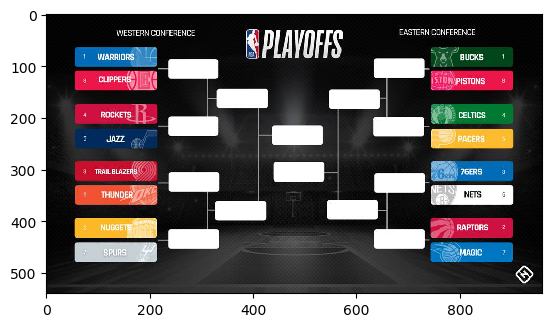

In [200]:
nbapb = plt.imread('nbapb.jpg')
fig_pict1, pict1 = plt.subplots()
pict1.imshow(nbapb)

fig_pict1

In [201]:
cheer = plt.imread('c.jpg')
cheer.shape

_Ah yes,cheerleaders. A great distraction for you when your team is getting blown out of the water and there is nothing else to do, but hope for a three second glimpse of your fantasy girl wearing your team colors._

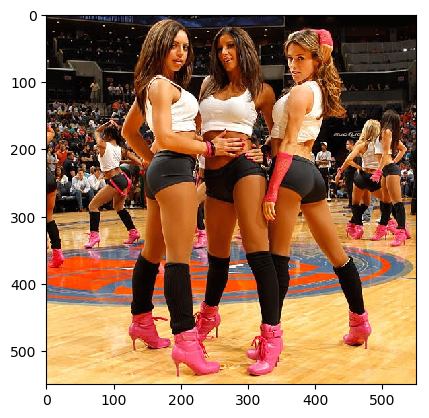

In [202]:
fig_pict, pict = plt.subplots()
pict.imshow(cheer)

fig_pict

_Ivan Knezić, April, 2019._